In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import quandl

In [17]:
apikey= 's8_hUUARe3sFyq3Chrxu' 

In [18]:
stock_data = quandl.get('EOD/CVX', authtoken=apikey)

In [19]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividend', 'Split',
       'Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Close', 'Adj_Volume'],
      dtype='object')

In [20]:
# Split data into train and test 

data = stock_data.Adj_Close

train = data[:int(0.8*(len(data)))]
test = data[int(0.8*(len(data))):]

In [21]:
# Convert dataset to a numpy array, and reshape the data to one column

training_set = train.values.reshape(-1,1)

Normalizng is rescaling values between 0 and 1. Standardization is shifting the distribution to have mean 0 and std dev 1 
Scaling the data can have a great impact on the result. For example, when a tanh activation function is used, and the value range is between -1 and 1, the model seems to converge faster and the validation error also does not jump dramatically after each epoch.

In [22]:
# Normalize the data. MinmaxScaler normalizes all the data be in the range of 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [23]:
# Create data with 30 timesteps. 

ts = 30
X_train = []
y_train = []

for i in range(ts,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-ts:i, 0])
    y_train.append(training_set_scaled[i,0])

# Convert the list to a NumPy array

X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
X_train.shape

(842, 30)

In [25]:
# Convert data(X_train) into a 3D array, with number of X_train samples, 30 timesteps, and a feature at each step
# 3D tensor with shape (batch_size, timesteps, input_size)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [26]:
X_train.shape[1]

30

In [45]:
# Build the LSTM model 
# units=50 - output nodes 
# return_sequence=True - ensures data is returned in a sequence and not scattered
# 20% of layers are dropped out

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', 
              loss = 'mean_squared_error', 
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 24, batch_size = 32)

Epoch 1/24
842/842 [==============================] - 11s 13ms/step - loss: 0.0748 - acc: 0.0024
Epoch 2/24
842/842 [==============================] - 3s 4ms/step - loss: 0.0148 - acc: 0.0024
Epoch 3/24
842/842 [==============================] - 3s 4ms/step - loss: 0.0095 - acc: 0.0024
Epoch 4/24
842/842 [==============================] - 3s 4ms/step - loss: 0.0096 - acc: 0.0024
Epoch 5/24
842/842 [==============================] - 3s 4ms/step - loss: 0.0103 - acc: 0.0024
Epoch 6/24
842/842 [==============================] - 3s 3ms/step - loss: 0.0092 - acc: 0.0024
Epoch 7/24
842/842 [==============================] - 3s 3ms/step - loss: 0.0093 - acc: 0.0024
Epoch 8/24
842/842 [==============================] - 3s 3ms/step - loss: 0.0080 - acc: 0.0024
Epoch 9/24
842/842 [==============================] - 3s 3ms/step - loss: 0.0081 - acc: 0.0024
Epoch 10/24
842/842 [==============================] - 3s 3ms/step - loss: 0.0077 - acc: 0.0024
Epoch 11/24
842/842 [==========================

In [46]:
# predict
# input data = last 30 records of the train dataset + all records of the test dataset
# inverse transform the scaled values to normal

dataset = pd.concat((train, test), axis = 0)

inputs = dataset[len(dataset) - len(test) - ts:].values  
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(ts, len(inputs)):
    X_test.append(inputs[i-ts:i, 0])    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

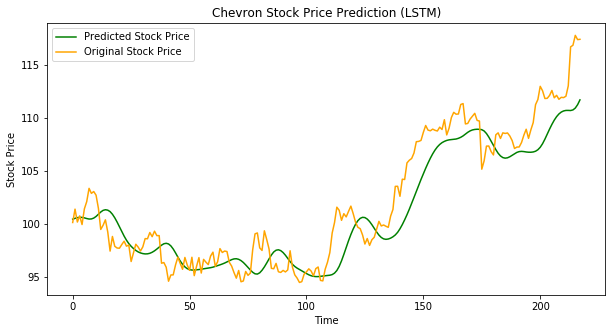

In [47]:
#plt.plot(test, color = 'black', label = 'Boeing Stock price')
plt.figure(figsize=(10,5))
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.plot(test.values, color='orange', label='Original Stock Price')
plt.title('Chevron Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [48]:
rmse = sqrt(mean_squared_error(test, predicted_stock_price))
print('RMSE:' , round(rmse,2))

RMSE: 2.37
